In [ ]:
''' This is Research Project titled ML Algorithms for Alberta Forest Occurence Prediction.
    This is the 8th Engineering Research Project, and is hereby delcared as
                            
                            Project Christopher
    
    Version 1.0 - Long Short-Term Memory Classifier
    Data Source: European Space Agency - ERA5
                 Government of Alberta - Historical Wildfire registry and Fire Weather Indices
                 Natural Resources Canada - Vegetation Classification of Canada
    
    AI Diederik - Hongik Ingan, For the Benefits of All Mankind
'''

In [ ]:
import sys
import os
import pandas as pd
import numpy as np

from joblib import dump
from sklearn import set_config
set_config(transform_output = "pandas")

# Custom utils
PROJECT_ROOT = '../'
MODEL_PATH = os.path.join(PROJECT_ROOT,'models','LSTM')
sys.path.append(PROJECT_ROOT)
from scripts.data_utils import load_downsampled_df, load_full_df, get_train_validation_df
from models.LSTM.functions import LSTM_test_train_validation_split, get_preprocess_pipeline, LSTM_classifier_wrapper, load_h5

In [2]:
# Load and split data

main_df = load_downsampled_df(PROJECT_ROOT)
validation_df, test_train_df = get_train_validation_df(main_df)
X_train, X_test, X_validation, y_train, y_test, y_validation = LSTM_test_train_validation_split(validation_df,test_train_df)
del main_df

In [3]:
## Create Pipeline. Save fitted preprocess pipeline ##

Data_pipeline = get_preprocess_pipeline()
X_train_processed = Data_pipeline.fit_transform(X_train)
X_test_processed = Data_pipeline.transform(X_test)

dump(Data_pipeline,os.path.join(MODEL_PATH,'LSTM_preprocess_pipeline.joblib'))

# Reshape X for LSTM
X_train_lstm = np.resize(X_train_processed,(X_train_processed.shape[0],1,X_train_processed.shape[1]))
X_test_lstm = np.resize(X_test_processed,(X_test_processed.shape[0],1,X_test_processed.shape[1]))

In [ ]:
# Load model (obtained from hyperband search below)

LSTM_clf = load_h5(os.path.join(MODEL_PATH,'LSTM.h5'))

**Evaluation**

In [17]:
from scripts.Visualization_functions import generate_visualizations, print_metrics, plot_roc_curve
from joblib import load

In [18]:
# Get the validation dataset
main_df = load_full_df(PROJECT_ROOT)
validation_df, test_train_df = get_train_validation_df(main_df)
_, X_test, X_validation, _, y_test, y_validation = LSTM_test_train_validation_split(validation_df,test_train_df)

In [19]:
# Import pipeline and preprocess validation data
Data_pipeline = load(os.path.join(MODEL_PATH,'LSTM_preprocess_pipeline.joblib'))

X_validation_processed = Data_pipeline.transform(X_validation)
X_validation_lstm= np.resize(X_validation_processed,(X_validation_processed.shape[0],1,X_validation_processed.shape[1]))

In [20]:
# Get predictions
y_val_pred_proba = LSTM_clf.predict(X_validation_lstm)

thresh = 0.9
y_val_pred = (y_val_pred_proba > thresh).astype(int)

5637/5637 ━━━━━━━━━━━━━━━━━━━━ 4s 729us/step


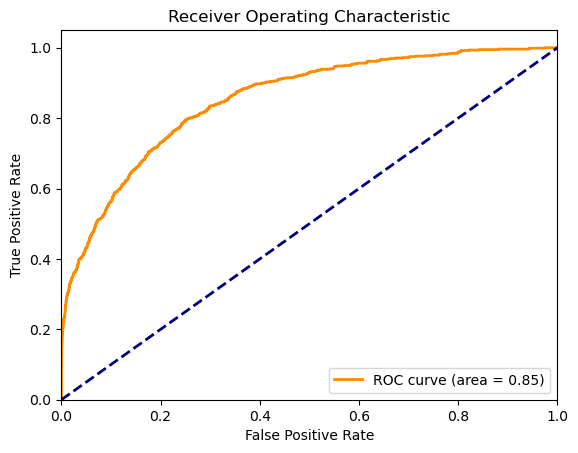

In [21]:
plot_roc_curve(y_validation,y_val_pred_proba)

In [22]:
generate_visualizations(X_validation_processed,y_val_pred,y_validation,main_df,os.path.join(MODEL_PATH,'LSTM_Visuals'))

In [23]:
print_metrics(y_validation,y_val_pred)

Validation set accuracy: 0.9949603872019338
f1 score:  0.21840068787618228
Precision: 0.30900243309002434
Recall: 0.16888297872340424


In [24]:
# Save validation probabilities
import numpy as np

np.save(os.path.join(MODEL_PATH,'RF_y_val_proba.npy'),y_val_pred_proba)
np.save(os.path.join(MODEL_PATH,'y1_validation.npy'),y_validation)

**Hyperparameter and model tuning**

In [9]:
# Keras hyperband search

import keras_tuner as kt

# Now use the wrapper function to create the model-building function for the tuner
input_shape = X_test_processed.shape[1]
model_builder = LSTM_classifier_wrapper(input_shape)

# Set up and run the hyperparameter tuner
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_epochs=10,
                     factor=3,
                     executions_per_trial=2,
                     overwrite=False,
                     directory=os.path.join(MODEL_PATH,'LSTM_Hyperband_tuning'),
                     project_name='LSTM_R2')

tuner.search(X_train_lstm, y_train, epochs=10, validation_data=(X_test_lstm, y_test))

Trial 26 Complete [00h 01m 02s]
val_auc: 0.8279149830341339

Best val_auc So Far: 0.8442699015140533
Total elapsed time: 00h 15m 16s


In [10]:
# Save model

best_classifiers = tuner.get_best_models(num_models=1)
best_classifier=best_classifiers[0]
best_classifier.fit(x=X_train_lstm, y=y_train, batch_size=64, epochs=5, verbose=1, validation_split=0.2)
best_classifier.save(os.path.join(MODEL_PATH,'LSTM_model.h5'))

Epoch 1/5


c:\Users\Chis\Documents\Python\ML\.conda\lib\site-packages\keras_tuner\src\tuners\hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
c:\Users\Chis\Documents\Python\ML\.conda\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.8537 - binary_accuracy: 0.8162 - loss: 0.4129 - val_auc: 0.8282 - val_binary_accuracy: 0.8631 - val_loss: 0.3339
Epoch 2/5
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.8500 - binary_accuracy: 0.8151 - loss: 0.4170 - val_auc: 0.8253 - val_binary_accuracy: 0.8621 - val_loss: 0.3385
Epoch 3/5
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.8521 - binary_accuracy: 0.8166 - loss: 0.4134 - val_auc: 0.8231 - val_binary_accuracy: 0.8620 - val_loss: 0.3378
Epoch 4/5
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.8559 - binary_accuracy: 0.8184 - loss: 0.4085 - val_auc: 0.8224 - val_binary_accuracy: 0.8625 - val_loss: 0.3459
Epoch 5/5
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.8529 - binary_accuracy: 0.8160 - loss: 0.4142 - val_auc: 0.8219 - val_binary_accuracy: 0.8616 - val_loss: 0.3506


In [15]:
# Classifier architecture

best_classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 100)         │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25)             │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,628 (244.64 KB)

 Trainable params: 62,626 (244.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)